# Fashion Recommendation System using Image Features

['women fashion', '__MACOSX']
['.DS_Store', 'anarkali suit with a long, olive green kurta adorned with intricate embroidery around the neckline and cuffs, paired with matching fitted trousers.jpg', 'Anarkali suit with a modern twist.jpg', 'Anarkali suit with fitted bodice with a high neckline.jpg', 'anarkali suit with intricate silver embellishments on the neckline, sleeves.jpg', 'anarkali suit with lavender in color with intricate white patterns throughout the fabric.jpg', 'anarkali suit. It consists of a turquoise skirt with detailed golden embroidery, a multicolored blouse with floral patterns, and an orange dupatta with lace borders.jpg', 'ark green, knee-length dress with short sleeves and a white, patterned neckline.jpg', 'beige top adorned with black dots and a green skirt.jpg', 'black and white gingham checkered A-line dress with a flared skirt.jpg'] 97


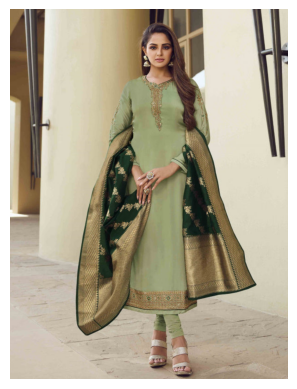

['/content/women_fashion/women fashion\\anarkali suit with a long, olive green kurta adorned with intricate embroidery around the neckline and cuffs, paired with matching fitted trousers.jpg', '/content/women_fashion/women fashion\\Anarkali suit with a modern twist.jpg', '/content/women_fashion/women fashion\\Anarkali suit with fitted bodice with a high neckline.jpg', '/content/women_fashion/women fashion\\anarkali suit with intricate silver embellishments on the neckline, sleeves.jpg', '/content/women_fashion/women fashion\\anarkali suit with lavender in color with intricate white patterns throughout the fabric.jpg', '/content/women_fashion/women fashion\\anarkali suit. It consists of a turquoise skirt with detailed golden embroidery, a multicolored blouse with floral patterns, and an orange dupatta with lace borders.jpg', '/content/women_fashion/women fashion\\ark green, knee-length dress with short sleeves and a white, patterned neckline.jpg', '/content/women_fashion/women fashion\\

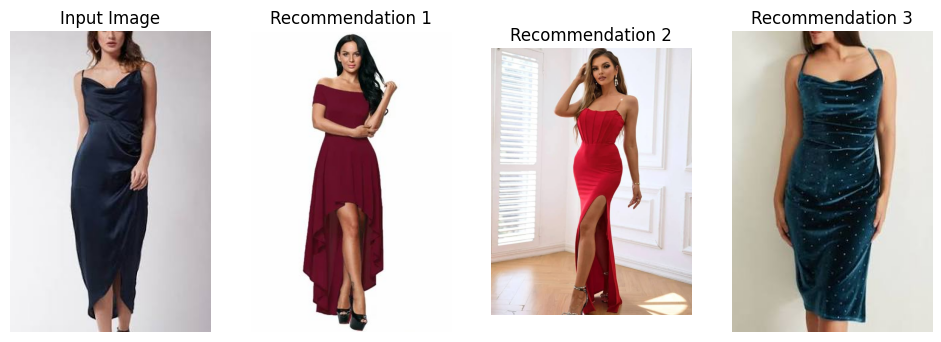

In [2]:
import os
from zipfile import ZipFile
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
import numpy as np
from scipy.spatial.distance import cosine

# Define paths
zip_file_path = r"C:\Users\NTC\Downloads\women-fashion.zip"
extraction_directory = '/content/women_fashion/'

# Ensure extraction directory exists
if not os.path.exists(extraction_directory):
    os.makedirs(extraction_directory)

# Extract zip file
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_directory)

# List extracted files
extracted_files = os.listdir(extraction_directory)
print(extracted_files[:10])

# Update extraction directory to include 'women fashion' subdirectory
extraction_directory_updated = os.path.join(
    extraction_directory, 'women fashion')

# List files in the updated directory
extracted_files_updated = os.listdir(extraction_directory_updated)
print(extracted_files_updated[:10], len(extracted_files_updated))

# Function to display an image


def display_image(file_path):
    try:
        image = Image.open(file_path)
        plt.imshow(image)
        plt.axis('off')
        plt.show()
    except (UnidentifiedImageError, IOError):
        print(f"Cannot identify image file {file_path}")


# Filter out non-image files
image_extensions = {'.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff'}
image_files = [f for f in extracted_files_updated if os.path.splitext(f)[
    1].lower() in image_extensions]

# Display the first image if available
if image_files:
    first_image_path = os.path.join(
        extraction_directory_updated, image_files[0])
    display_image(first_image_path)
else:
    print("No valid image files found.")

# Get the list of image file paths
image_paths_list = [file for file in glob.glob(os.path.join(
    extraction_directory_updated, '*.*')) if file.endswith(('.jpg', '.png', '.jpeg', 'webp'))]
print(image_paths_list)

# Load pre-trained VGG16 model for feature extraction
base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.output)

# Preprocess image function


def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array_expanded)

# Extract features function


def extract_features(model, preprocessed_img):
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / \
        np.linalg.norm(flattened_features)
    return normalized_features


# Extract features for all images
all_features = []
all_image_names = []
for img_path in image_paths_list:
    preprocessed_img = preprocess_image(img_path)
    features = extract_features(model, preprocessed_img)
    all_features.append(features)
    all_image_names.append(os.path.basename(img_path))

# Function to recommend fashion items


def recommend_fashion_items_cnn(input_image_path, all_features, image_paths_list, model, top_n=4):
    input_image_path = os.path.normpath(input_image_path)
    all_image_names = [os.path.normpath(path) for path in image_paths_list]

    print(f"Input Image Path: {input_image_path}")
    print("All Image Names:")
    for path in all_image_names:
        print(path)

    preprocessed_img = preprocess_image(input_image_path)
    input_features = extract_features(model, preprocessed_img)

    similarities = [1 - cosine(input_features, other_feature)
                    for other_feature in all_features]
    similar_indices = np.argsort(similarities)[-top_n:]

    try:
        input_index = all_image_names.index(input_image_path)
        similar_indices = [
            idx for idx in similar_indices if idx != input_index]
    except ValueError as e:
        print(f"Error: {e}")
        return

    plt.figure(figsize=(15, 10))
    try:
        plt.subplot(1, top_n + 1, 1)
        plt.imshow(plt.imread(input_image_path))
        plt.title("Input Image")
        plt.axis('off')
    except (UnidentifiedImageError, IOError):
        print(f"Cannot display input image: {input_image_path}")

    for i, idx in enumerate(similar_indices, 2):
        try:
            plt.subplot(1, top_n + 1, i)
            plt.imshow(plt.imread(image_paths_list[idx]))
            plt.title(f"Recommendation {i-1}")
            plt.axis('off')
        except (UnidentifiedImageError, IOError):
            print(f"Cannot display image at index {
                  idx}: {image_paths_list[idx]}")

    plt.show()


# Example usage
input_image_path = os.path.join(extraction_directory_updated,
                                'dark, elegant, sleeveless dress that reaches down to about mid-calf.jpg')
recommend_fashion_items_cnn(
    input_image_path, all_features, image_paths_list, model, top_n=4)